# Lecture 2 - Fourier reconstruction

# Contents

* The Fourier transform
* The Fourier-Slice Theorem
* Fourier reconstruction
* Assignments

# The Fourier transform

The Fourier transform of a function $g : \mathbb{R} \rightarrow \mathbb{R}$ is given by 

$$\widehat{g}(\xi) = \int_{\mathbb{R}} g(x) e^{-2\pi\imath x \xi} \mathrm{d}x.$$

The inverse transform is given by 

$$g(x) = \int_{\mathbb{R}} \widehat{g}(\xi) e^{2\pi\imath x \xi} \mathrm{d}\xi.$$


Similarly, for a function $g : \mathbb{R}^n \rightarrow \mathbb{R}$

$$\widehat{g}(\boldsymbol{\xi}) = \int_{\mathbb{R}^n} g(\mathbf{x}) e^{-2\pi\imath x \cdot \boldsymbol{\xi}} \mathrm{d}\mathbf{x}.$$

With inverse

$$g(\mathbf{x}) = \int_{\mathbb{R}^n} \widehat{g}(\boldsymbol{\xi}) e^{2\pi\imath x \cdot \boldsymbol{\xi}} \mathrm{d}\boldsymbol{\xi}.$$

# The Fourier-Slice Theorem

The Fourier-Slice Theorem relates the 2D-Fourier transform of $u$ to the 1D-Fourier transform of $f$:

$$\widehat{f}(\sigma,\theta) = \widehat{u}(\sigma \mathbf{n}_\theta),$$

with

$$\widehat{f}(\sigma,\theta) = \int_{\mathbb{R}} f(s,\theta) e^{-2\pi\imath \sigma s}\mathrm{d}s,$$

$$\widehat{u}(\mathbf{k}) = \int_{\mathbb{R}^2} u(\mathbf{x}) e^{-2\pi\imath \mathbf{k}\cdot \mathbf{x}}\mathrm{d}\mathbf{x},$$

$$\mathbf{n}_\theta = (\cos\theta,\sin\theta).$$

We can visualise this as follows

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Radon_transform_via_Fourier_transform.png/2000px-Radon_transform_via_Fourier_transform.png)

# Fourier reconstruction

* In principle, we can reconstruct the image by performing an inverse Fourier transform
* Having collected *discrete* measurements $f_{ij} = f(s_i,\theta_j)$, we only have partial information on the Fourier transform of $u$
* Ultimately, we will represent $u$ on a grid of pixels with intenties $u_i = u(\mathbf{x}_i)$

## The Discrete Fourier Transform

The *discrete Fourier transform (DFT)* of a sequence $\{g_i\}_{i=0}^n$ is defined as

$$\widehat{g}_i = \sum_{j=0}^{n-1} g_j \exp\left(-\frac{2\pi\imath}{n} ij\right), \quad i = 0, \ldots, n-1.$$

When $g_i$ samples $g$ at a grid with spacing $\Delta x$, its Fourier spectrum $\widehat{g}$ is sampled with $\Delta \xi = (n\Delta x)^{-1}$.

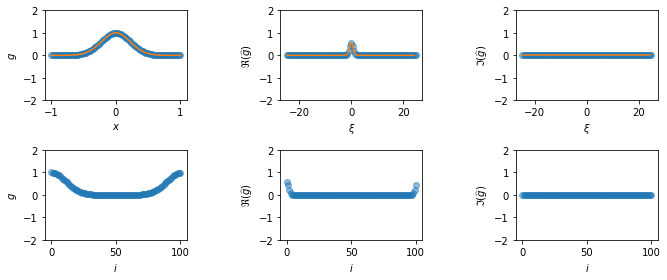

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, fftshift,ifftshift

# Fourier transform pair, see https://en.wikipedia.org/wiki/Fourier_transform#Square-integrable_functions,_one-dimensional
a = 10
g = lambda x : np.exp(-a*x**2)
gh = lambda xi : np.sqrt(np.pi/a)*np.exp(-((xi*np.pi)**2)/a)

# sampling
n = 100
x = np.linspace(-1,1,n)
xi = fftshift(fftfreq(n,x[1]-x[0]))

ns = 101
xs = ifftshift(np.linspace(-1,1,ns))
xis = fftfreq(ns,xs[1]-xs[0])

# plot
fig,ax = plt.subplots(2,3)

ax[0,0].plot(xs,g(xs),'o',alpha=.5)
ax[0,0].plot(x,g(x))
ax[0,0].set_xlabel(r'$x$')
ax[0,0].set_ylabel(r'$g$')
ax[0,0].set_ylim([-2,2])

ax[0,1].plot(xis,2*np.real(fft(g(xs)))/ns,'o',alpha=.5)
ax[0,1].plot(xi,np.real(gh(xi)))
ax[0,1].set_xlabel(r'$\xi$')
ax[0,1].set_ylabel(r'$\Re(\widehat{g})$')
ax[0,1].set_ylim([-2,2])

ax[0,2].plot(xis,2*np.imag(fft(g(xs)))/ns,'o',alpha=.5)
ax[0,2].plot(xi,np.imag(gh(xi)))
ax[0,2].set_xlabel(r'$\xi$')
ax[0,2].set_ylabel(r'$\Im(\widehat{g})$')
ax[0,2].set_ylim([-2,2])

ax[1,0].plot(g(xs),'o',alpha=.5)
ax[1,0].set_xlabel(r'$i$')
ax[1,0].set_ylabel(r'$g$')
ax[1,0].set_ylim([-2,2])

ax[1,1].plot(2*np.real(fft(g(xs)))/ns,'o',alpha=.5)
ax[1,1].set_xlabel(r'$i$')
ax[1,1].set_ylabel(r'$\Re(\widehat{g})$')
ax[1,1].set_ylim([-2,2])

ax[1,2].plot(2*np.imag(fft(g(xs)))/ns,'o',alpha=.5)
ax[1,2].set_xlabel(r'$i$')
ax[1,2].set_ylabel(r'$\Im(\widehat{g})$')
ax[1,2].set_ylim([-2,2])


fig.tight_layout()
fig.set_figwidth(10)

plt.savefig('./figures/lecture2/fourier1.png',dpi=300)

We need to be carefull when trying to relate the samples $g_i, \widehat{g}_i$ to the underlying functions $g, \widehat{g}$.

![](./figures/lecture2/fourier1.png)

In matrix-vector notation, we express this as

$$\widehat{\mathbf{g}} = F\mathbf{g},$$

with $F_{ij} = \exp\left(-\frac{2\pi\imath}{n} ij\right)$.

The inverse is given by

$$F^{-1} = n^{-1} F^*.$$

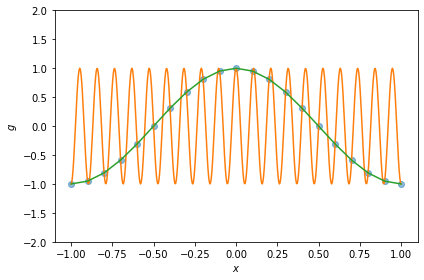

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, fftshift,ifftshift

# Fourier transform pair, see https://en.wikipedia.org/wiki/Fourier_transform#Square-integrable_functions,_one-dimensional
a = 19*np.pi
g = lambda x : np.cos(a*x)

# sampling
n = 500
x = np.linspace(-1,1,n)
xi = fftshift(fftfreq(n,x[1]-x[0]))

ns = 21
xs = np.linspace(-1,1,ns)
xis = fftfreq(ns,xs[1]-xs[0])

# plot
fig,ax = plt.subplots(1,1)

ax.plot(xs,g(xs),'o',alpha=.5)
ax.plot(x,g(x))
ax.plot(xs,np.real(ifft(fft(g(xs)))))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$g$')
ax.set_ylim([-2,2])

fig.tight_layout()

plt.savefig('./figures/lecture2/fourier2.png',dpi=300)

Be aware that some interesting things may happen with the DFT, when subsampling or truncating the signals.

![](./figures/lecture2/fourier2.png)

## The Fast Fourier Transform

A naive implementation would require $\mathcal{O}(n^2)$ operations to multiply by $F$. With some clever tricks, however, it can be done in $\mathcal{O}(n\log n)$.

To illustrate the concept, consider $n = 2^p$ and express the DFT as

$$\sum_{j=0}^{n-1} g_j \exp\left(-\frac{2\pi\imath}{n} ij\right) = \sum_{j=0}^{n/2-1} g_{2j} \exp\left(-\frac{2\pi\imath}{n} i(2j)\right) + \sum_{j=0}^{n/2-1} g_{2j+1} \exp\left(-\frac{2\pi\imath}{n} i(2j+1)\right)$$

$$ = \underbrace{\sum_{j=0}^{n/2-1} g_{2j} \exp\left(-\frac{2\pi\imath}{n/2} ij\right)}_{E_i} + \exp\left(-\frac{2\pi\imath}{n} i\right)\underbrace{\sum_{j=0}^{n/2-1} g_{2j+1} \exp\left(-\frac{2\pi\imath}{n/2} ij\right)}_{O_i}$$

We need only compute $E_i$ and $O_i$ for $i = 0, \ldots, n/2-1$ since

$$\widehat{g}_i = E_i + e^{-\frac{2\pi\imath}{n} i} O_i, \quad \widehat{g}_{i+n/2} = E_i - e^{-\frac{2\pi\imath}{n} i} O_i$$

This *divide-and-conquer* technique leads to an overall complexity of $\mathcal{O}(n\log n)$.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/DIT-FFT-butterfly.svg/600px-DIT-FFT-butterfly.svg.png)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/FFT_Butterfly_radix8.svg/520px-FFT_Butterfly_radix8.svg.png)

## Interpolation

Applying the Fourier transform to $f_{ij}$ gives us samples of $\widehat{u}$ at wavenumbers 

$$\{(\sigma_i \mathbf{n}_{\theta_j})\},$$ 

with $\sigma_i = i \cdot (n h)^{-1}$ for $i = -(n-1)/2, \ldots, 0, \ldots, (n-1)/2$ (assuming again that $f_{ij} = f(i \cdot h , \theta_j)$ and $n$ odd)

To usefully apply the inverse DFT, we need $\widehat{u}$ at wavenumbers 

$$\{(i\cdot (n h)^{-1}, j\cdot (n h )^{-1})\},$$

for $i,j = -(n-1)/2, \ldots, 0, \ldots, (n-1)/2$.

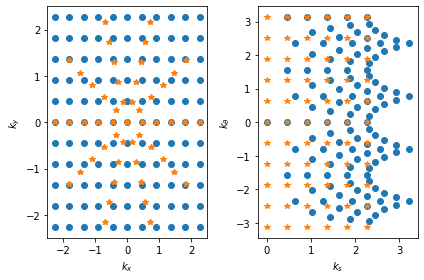

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftfreq

n = 11
m = 11

x = np.linspace(-1,1,n)
h = 2/(n-1)

kx = fftfreq(n, h)
ky = fftfreq(n, h)
kxx,kyy = np.meshgrid(kx,ky)

kr = fftfreq(n, h)
theta = np.linspace(-np.pi,np.pi,m)
krr,tt = np.meshgrid(kr,theta)

fig,ax = plt.subplots(1,2)

ax[0].plot(kxx.ravel(),kyy.ravel(),'o')
ax[0].plot((krr*np.cos(tt)).ravel(),(krr*np.sin(tt)).ravel(),'*')
ax[0].set_xlabel(r'$k_x$')
ax[0].set_ylabel(r'$k_y$')


ax[1].plot(np.sqrt(kxx**2+kyy**2).ravel(),np.arctan2(kyy,kxx).ravel(),'o')
ax[1].plot(krr.ravel(),tt.ravel(),'*')
ax[1].set_xlabel(r'$k_s$')
ax[1].set_ylabel(r'$k_\theta$')
ax[1].set_xlim([-.2,1.5*np.max(kx)])

fig.tight_layout()

plt.savefig('./figures/lecture2/grids.png',dpi=300)

![](./figures/lecture2/grids.png)

In interpolation we aim to approximate the value of a function $g$ at $(x,y)$ from its values at nearby points $g_i = g(x_i,y_i)$.

* Linear interpolation uses 3 nearby points
* Bi-linear interplation uses 4 nearby points

For linear interpolation, we use a first order polynomial of the form

$$p(x,y) = a \cdot x + b \cdot y + c,$$

and set up a system of equations for $(a,b,c)$ by demanding that $p(x_i,y_i) = g_i$.

For bi-linear interpolation, we use a polynomial of the form

$$p(x,y) = a \cdot x \cdot y + b \cdot x + c \cdot y + d,$$

and set up a system of equations for $(a,b,c,d)$ by demanding that $p(x_i,y_i) = g_i$.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Bilinear_interpolation_visualisation.svg/340px-Bilinear_interpolation_visualisation.svg.png)

## 1D example

```python

def lininterp1d(x,g,xs):
    """
    Linear interpolation from regular grid.
    
    x  - input grid (regularly spaced), 1d array of length n
    g  - function values, 1d array of length n
    xs - values at which to evaluate, 1d array of length ns
    """

    n = len(x)
    ns = len(xs)
    gs = np.zeros(ns)
    
    h = x[1] - x[0]
    
    for i in range(ns):
        j = int((xs[i] - x[0]) // h) # find j such that x[j] <= xs[i] < x[j+1]
        if 0 <= j < n-1:
            gs[i] = ((x[j+1] - xs[i])/h)*g[j] + ((xs[i] - x[j])/h)*g[j+1]
        else:
            gs[i] = 0
        
    return gs
```

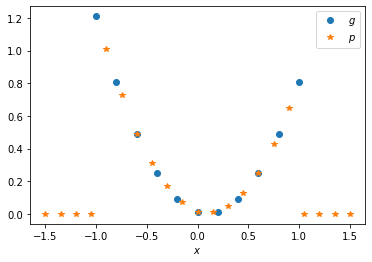

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def lininterp1d(x,g,xs):
    """
    Linear interpolation from regular grid.
    
    x  - input grid (regularly spaced), 1d array of length n
    g  - function values, 1d array of length n
    xs - values at which to evaluate, 1d array of length ns
    """

    n = len(x)
    ns = len(xs)
    gs = np.zeros(ns)
    
    h = x[1] - x[0]
    
    for i in range(ns):
        j = int((xs[i] - x[0]) // h) # find j such that x[j] <= xs[i] < x[j+1]
        if 0 <= j < n-1:
            gs[i] = ((x[j+1] - xs[i])/h)*g[j] + ((xs[i] - x[j])/h)*g[j+1]
        else:
            gs[i] = 0
        
    return gs

x = np.linspace(-1,1,11)
g = (x-.1)**2
xs = np.linspace(-1.5,1.5,21)
gs = lininterp1d(x,g,xs)

plt.plot(x,g,'o',label=r'$g$')
plt.plot(xs,gs,'*',label=r'$p$')
plt.xlabel(r'$x$')
plt.legend()

plt.savefig('./figures/lecture2/interpolation.png',dpi=300)

![](./figures/lecture2/interpolation.png)

# Assignments

## Assignment 1

Implement a function to bi-linearly interpolate data from a polar grid `r,theta` to a cartesian grid `x,y`. Use the following template 

```python
def rad2cart(data, r, theta, x, y):
    """
    Bi-linear interpolation from radial grid (r,theta) to cartesian grid (x,y).
    
    Input: 
        data     - 2d array of size (nr,ntheta) containing values on the radial grid
        r, theta - 1d arrays of size nr and nt containing the polar gridpoints
        x,y      - 1d arrays of size nx and ny containing the cartesian gridpoints
        
    Output:
        result   - 2d array of size (nx,nt) containing the interpolated values
    """

```

## Assignment 2

Use your interpolation method to reconstruct the following data

```python
# settings
nx = 400
na = 400
theta = np.linspace(0., 180., na)
sigma = 1

# phantom
u = shepp_logan_phantom()

# sinogram
f = radon(u, theta=theta)
f_noisy = f + sigma * np.random.randn(nx,na)
```

* perform a one-dimensional fft of the sinogram; you can use `fftshift` and `ifftshift` to switch between the regular and DFT ordering of grid.
* define the corresponding polar Fourier grid (according to the Fourier Slice Theorem)
* interpolate the data on a euclidian grid
* Vary the noise level `sigma` and angular sampling `na`; is Fourier reconstruction more or less sensitive to noise and subsampling than `iradon`?